In [1]:
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
# torch.multiprocessing.set_sharing_strategy('file_system')
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, write_gt_csv
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from l5kit.dataset import AgentDataset
from l5kit.geometry import transform_point, transform_points

import os

In [2]:
import l5kit
import torch

import os

from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.rasterization import build_rasterizer
from l5kit.dataset import EgoDataset, AgentDataset

from torch.utils.data import DataLoader

from torch import nn, optim
from torchvision.models.resnet import resnet18, resnet50, resnet34

from tqdm import tqdm

torch.cuda.is_available()

True

In [3]:
# nikhil: changed history step size to 3 and num frames to 5
cfg = {
    'format_version': 4,
    'model_params': {
        'history_num_frames': 5,
        'history_step_size': 3,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1
    },
    
    'raster_params': {
        'raster_size': [300, 300],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5
    },
    
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 2
    },
    
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 64,
        'shuffle': True,
        'num_workers': 4
    },
    
    'val_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 16,
        'shuffle': False,
        'num_workers': 4
    }

}

In [4]:
ls /root/input

aerial_map/                       scenes/
meta.json                         semantic_map/
multi_mode_sample_submission.csv  single_mode_sample_submission.csv


In [5]:
DIR_INPUT = "/root/input"
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

In [6]:
rasterizer = build_rasterizer(cfg, dm)

train_zarr = ChunkedDataset(dm.require(cfg['train_data_loader']["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset,
                             shuffle=cfg['train_data_loader']["shuffle"], #nikhil: should be shuffled, train set
                             batch_size=cfg['train_data_loader']["batch_size"],
                             num_workers=cfg['train_data_loader']["num_workers"],
                             pin_memory=True)

In [7]:
val_zarr = ChunkedDataset(dm.require(cfg['val_data_loader']["key"])).open()
val_dataset = AgentDataset(cfg, val_zarr, rasterizer)
val_dataloader = DataLoader(val_dataset,
                             shuffle=cfg['val_data_loader']["shuffle"],
                             batch_size=cfg['val_data_loader']["batch_size"],
                             num_workers=cfg['val_data_loader']["num_workers"])

In [8]:
class LyftModel(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        
        # nikhil: changed to resnet18
        self.backbone = resnet18(pretrained=False)
        
        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )
        
        # This is 512 for resnet18 and resnet34;
        # And it is 2048 for the other resnets
        backbone_out_features = 512
        
        # X, Y coords for the future positions (output shape: Bx50x2)
        num_targets = 2 * cfg["model_params"]["future_num_frames"]

        # You can add more layers here.
        # nikhil: adding some layers here
        self.head = nn.Sequential(
            nn.Linear(in_features=backbone_out_features, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.2)
        )

        self.logit = nn.Linear(4096, out_features=num_targets)
        
    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)
        
        x = self.head(x)
        x = self.logit(x)
        
        return x

In [9]:
# compiling model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = LyftModel(cfg).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.MSELoss(reduction="none")

cuda:0


In [10]:
def batch_transform_points(points: torch.Tensor, transf_matrix: torch.Tensor) -> np.ndarray:
    """
    Args:
        points (torch.Tensor): Input points (BxNx2) or (BxNx3).
        transf_matrix (torch.Tensor): Bx3x3 or Bx4x4 transformation matrix for 2D and 3D input respectively
    Returns:
        torch.Tensor: array of shape (B,N,2) for 2D input points, or (B,N,3) points for 3D input points
    """
    assert len(points.shape) == len(transf_matrix.shape) == 3
    assert transf_matrix.shape[1] == transf_matrix.shape[2]

    if points.shape[2] not in [2, 3]:
        raise AssertionError("Points input should be (B, N, 2) or (B, N,3) shape, received {}".format(points.shape))

    assert points.shape[2] == transf_matrix.shape[2] - 1, "points dim should be one less than matrix dim"

    num_dims = len(transf_matrix[0]) - 1

    transf_matrix = transf_matrix.transpose(1, 2)
    # print(points.shape, transf_matrix.shape)

    # print(torch.bmm(points, transf_matrix[:, :num_dims, :num_dims]).shape)
    # print(transf_matrix[:, -1:-1, :num_dims].shape)
    return torch.bmm(points, transf_matrix[:, :num_dims, :num_dims]) + transf_matrix[:, -1, :num_dims].reshape(len(transf_matrix), 1, -1)

In [11]:
print('sane')

sane


In [12]:
len(train_dataloader)

351512

In [17]:
model_state = torch.load("models/resnet_18_    3.9828epoch_steps_vast_ai_oct_11_2020.pth")

In [18]:
model.load_state_dict(model_state)

<All keys matched successfully>

/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/usr/local/lib/python3.6/dist-packages/l5kit/dataset/agent.py:115: RuntimeWarning: disable_traffic_light_faces not found in config, this will raise an error in the future
  return self.get_frame(scene_index, state_index, track_id=track_id)
/usr/local/lib/python3.6/dist-packages/l

starting


loss: 1.0648680925369263 loss(avg): 1.6038929142057896:   0%|          | 1000/351512 [38:48<148:47:40,  1.53s/it]

val_loss: tensor(2.4508, device='cuda:0')


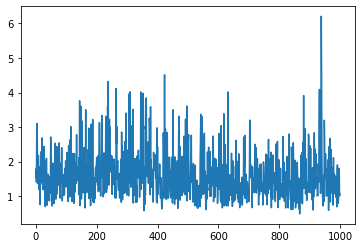

loss: 0.6688884496688843 loss(avg): 1.5465699209570885:   1%|          | 2000/351512 [1:19:25<248:29:34,  2.56s/it]

In [ ]:
tr_it = iter(train_dataloader)
val_it = iter(val_dataloader)

# val_data = next(val_it)

progress_bar = tqdm(range(len(train_dataloader)))

losses_train = []
losses_val = []

print('starting')

# plt.fig()

for iter_ind in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    
    # forward pass
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)
#     targets = batch_transform_points(data["target_positions"].float().to(device), data["raster_from_agent"].float().to(device))
    
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)

    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    plot_freq = 1000
    
    if iter_ind % plot_freq == 0 and iter_ind != 0:
#         plt.plot(outputs)
        with torch.no_grad():
            plt.plot(range(iter_ind), losses_train)
            model.eval()
            val_loss_list = []
            for val_indx in range(200):
                try:
                    val_data = next(val_it)
                except StopIteration:
                    val_it = iter(val_dataloader)
                    val_data = next(val_it)
                val_inputs = val_data["image"].to(device)
                val_target_availabilities = val_data["target_availabilities"].unsqueeze(-1).to(device)
                val_targets = val_data["target_positions"].to(device)
#                 val_targets = batch_transform_points(val_data["target_positions"].float().to(device), val_data["raster_from_agent"].float().to(device))
                val_outputs = model(val_inputs).reshape(val_targets.shape)
                val_loss = criterion(val_outputs, val_targets)

                # not all the output steps are valid, but we can filter them out from the loss using availabilities
                val_loss = val_loss * val_target_availabilities
                val_loss = val_loss.mean()
                val_loss_list.append(val_loss)

        
        vlm = sum(val_loss_list)/len(val_loss_list)
        losses_val.append(vlm.cpu().detach().numpy())
        print('val_loss:', vlm)
        plt.plot(range(plot_freq,iter_ind+1, plot_freq), losses_val, color="red")
        torch.save(model.state_dict(), 'models/resnet_18_{:4.4f}epoch_steps_vast_ai_oct_16_2_2020.pth'.format(100*iter_ind/len(train_dataloader)))
        plt.savefig("models/resnet_18_{:4.4f}epoch_steps_vast_ai_oct_16_2_2020.jpg".format(100*iter_ind/len(train_dataloader)))
        plt.show()
        

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

In [ ]:
torch.save(model.state_dict(), f'resnet_18_1epoch_steps_vast_ai_oct_11_2020.pth')

In [ ]:
# plt.close()
progress_bar = tqdm(range(20000))

losses_train = []
losses_val = []

print('starting')

# plt.fig()

for iter_ind in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    model.train()
    torch.set_grad_enabled(True)
    
    # forward pass
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = batch_transform_points(data["target_positions"].float().to(device), data["raster_from_agent"].float().to(device))
    
    outputs = model(inputs).reshape(targets.shape)
    loss = criterion(outputs, targets)

    # not all the output steps are valid, but we can filter them out from the loss using availabilities
    loss = loss * target_availabilities
    loss = loss.mean()
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    plot_freq = 1000
    
    if iter_ind % plot_freq == 0 and iter_ind != 0:
        with torch.no_grad():
            plt.plot(range(iter_ind), losses_train)
            model.eval()
            val_loss_list = []
            val_len = 1000
            for val_indx in range(val_len):
                try:
                    val_data = next(val_it)
                except StopIteration:
                    val_it = iter(val_dataloader)
                    val_data = next(val_it)
                val_inputs = val_data["image"].to(device)
                val_target_availabilities = val_data["target_availabilities"].unsqueeze(-1).to(device)
                val_targets = batch_transform_points(val_data["target_positions"].float().to(device), val_data["raster_from_agent"].float().to(device))
                val_outputs = model(val_inputs).reshape(val_targets.shape)
                val_loss = criterion(val_outputs, val_targets)

                # not all the output steps are valid, but we can filter them out from the loss using availabilities
                val_loss = val_loss * val_target_availabilities
                val_loss = val_loss.mean()
                val_loss_list.append(val_loss)

        
        vlm = sum(val_loss_list)/len(val_loss_list)
        losses_val.append(vlm.cpu().detach().numpy())
        print('val_loss:', vlm)
        plt.scatter(range(plot_freq,iter_ind+1, plot_freq), losses_val, color="red")
        plt.show()
        

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

In [ ]:
torch.save(model.state_dict(), f'resnet_18_30k_oct_8th.pth')

In [ ]:
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []

agent_ids = []

losses_val = []
progress_bar = tqdm(validate_dataloader)
for idx, data in enumerate(progress_bar):
    
#     if idx == 5:
#         break
    
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].unsqueeze(-1).to(device)
    targets = data["target_positions"].to(device)

    outputs = model(inputs).reshape(targets.shape)
    
    loss = criterion(outputs, targets)
    loss = loss * target_availabilities
    loss = loss.mean()
    
    losses_val.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_val)}")
    